# Demo network with no spontaneous but successful triggered replay

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import numpy as np

from disp import set_font_size
from replay import smln, plot, analysis


XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]

In [2]:
def rerun_smln(f_name, smln_id, rng_seed, d_smln=None, trg=None, change_m_params=None, epochs=None, t_lim=None):
    
    df, rslts, header = analysis.make_df(f_name)
    
    if epochs is None:
        epochs = []
        
    # rerun smln
    m_params = copy(header['m_params'])
    s_params = copy(header['s_params'])

    rslt = rslts[smln_id]
    assert rslt['SMLN_ID'] == smln_id
    
    for param in header['params_varied']:
        m_params[param] = rslt['PARAMS'][param]
        print(param, ':', rslt['PARAMS'][param])

    s_params['RNG_SEED'] = rng_seed
    
    if d_smln is not None:
        s_params['schedule']['D_SMLN'] = d_smln
        
    if trg is not None:
        s_params['TRG'] = trg
        
    if change_m_params is not None:
        for param, param_val in change_m_params.items():
            m_params[param] = param_val

    print('Running smln...')
    rslt_rerun = smln.run(m_params, s_params)
    print('Smln complete.')

    # analyze results
    print('Desired metrics:')
    print(rslt['METRICS'][str(rng_seed)])
    print('Actual metrics:')
    print(analysis.get_metrics(rslt_rerun, header['a_params']))

    # plot results
    ## potentiation profile
    ax, c_ax = plot.ltp_ie_profile(rslt_rerun)

    ## add PC labels
    for ctr, (x, y) in enumerate(XYS_RASTER):
        ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

    ## selected replay epoch spike sequences
    for epoch in epochs:
        fig, axs = plot.spike_seq(rslt_rerun, epoch=epoch)

    ## raster for selected PCs
    fig, axs = plot.raster_with_pc_inh(
        rslt_rerun,
        XYS_RASTER,
        colors=np.zeros(len(XYS_RASTER)),
        cmap='inferno',
        nearest=1,
        epoch=(0, 10),
        trg_plt=[],
        y_lim=(-1, 13),
        y_ticks=[0, 3, 6, 9, 12],
        smoothness=4)
    
    if t_lim is not None:
        for ax in axs:
            ax.set_xlim(t_lim)

    ## shade selected replay epochs
    for epoch in epochs:
        axs[0].axvspan(*epoch, color='b', alpha=0.15)
        axs[1].axvspan(*epoch, color='b', alpha=0.15)
        axs[2].axvspan(*epoch, color='b', alpha=0.15)
        
    return rslt_rerun

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SGM_MAX : 1.8399999999999999
R_G : 125.0
Running smln...
Smln complete.
Desired metrics:
{'evt_ct': 0, 'evt_dur': -1, 'fr_trj': -1, 'one_way_ct': 0, 'fr_ntrj': -1}
Actual metrics:
{'evt_ct': 1, 'evt_dur': 0.21299999999999997, 'fr_trj': 4.65215535638071, 'one_way_ct': 1, 'fr_ntrj': 0.40304721410222344}


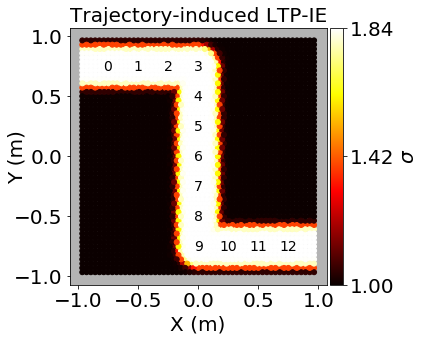

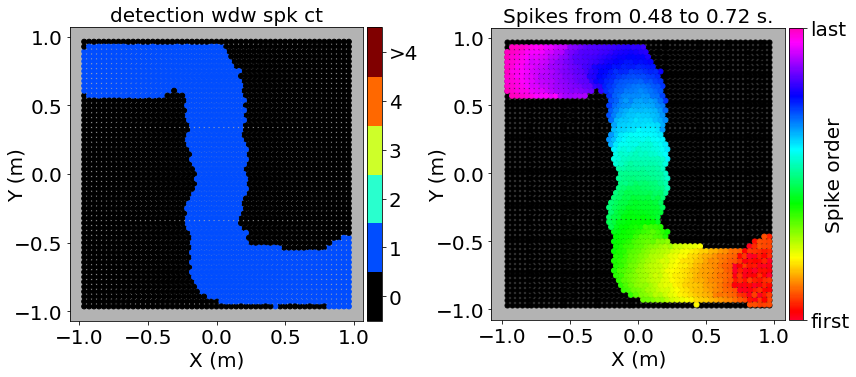

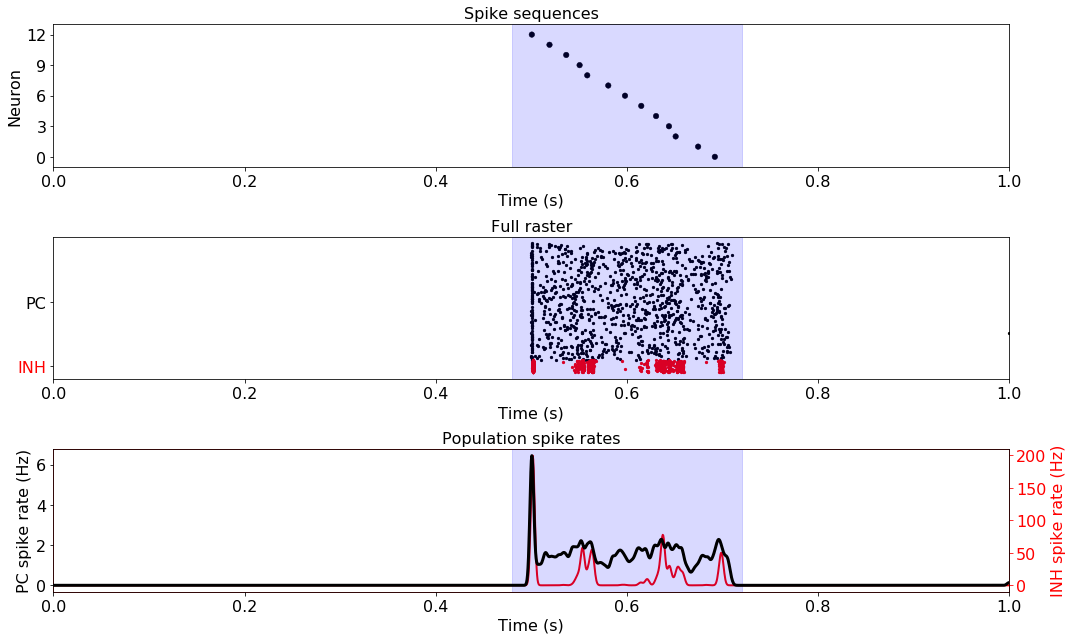

In [3]:
rerun_smln(
    'PARAM_SWEEP_RESULTS_4_R_G_SGM_MAX.txt',
    smln_id=178,
    rng_seed=0,
    d_smln=1,
    trg=[{'T': 0.5, 'A': 0.01, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75}],
    change_m_params={'R_G': 200, 'W_PC_G': .005},
    epochs=[(.48, .72)],
    t_lim=(0, 1));

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SGM_MAX : 1.8399999999999999
R_G : 125.0
Running smln...
Smln complete.
Desired metrics:
{'evt_ct': 0, 'evt_dur': -1, 'fr_trj': -1, 'one_way_ct': 0, 'fr_ntrj': -1}
Actual metrics:
{'evt_ct': 3, 'evt_dur': 0.14466666666666658, 'fr_trj': 4.367670149681526, 'one_way_ct': 3, 'fr_ntrj': 0.31786061956951517}


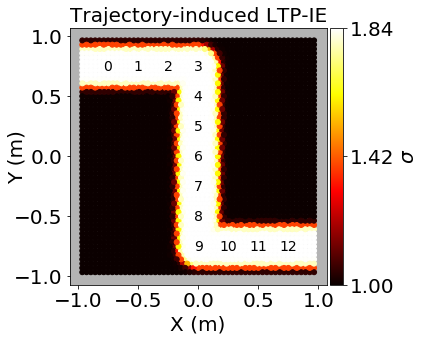

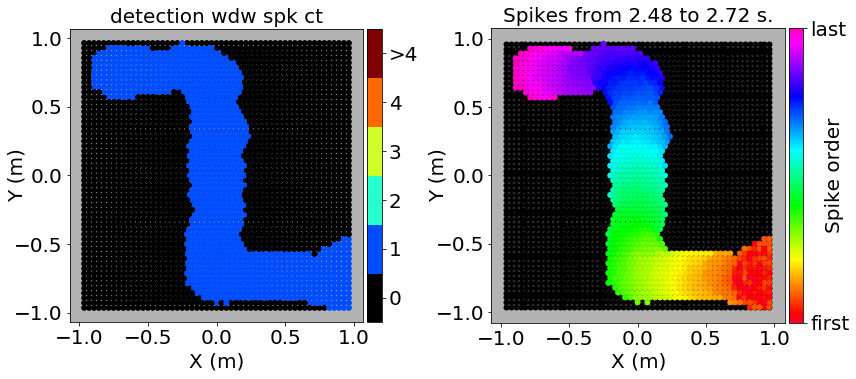

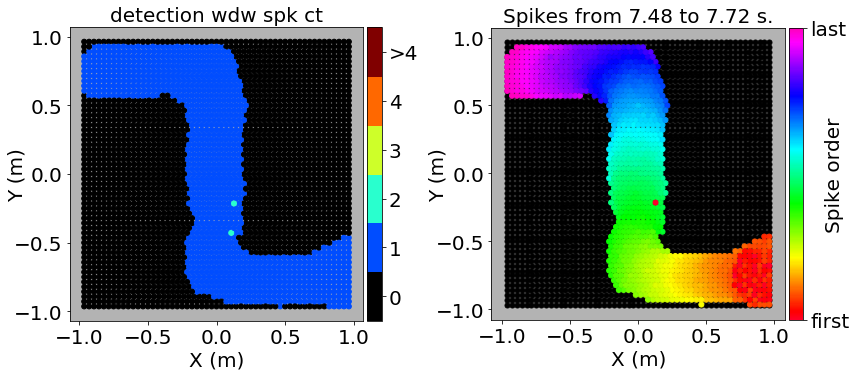

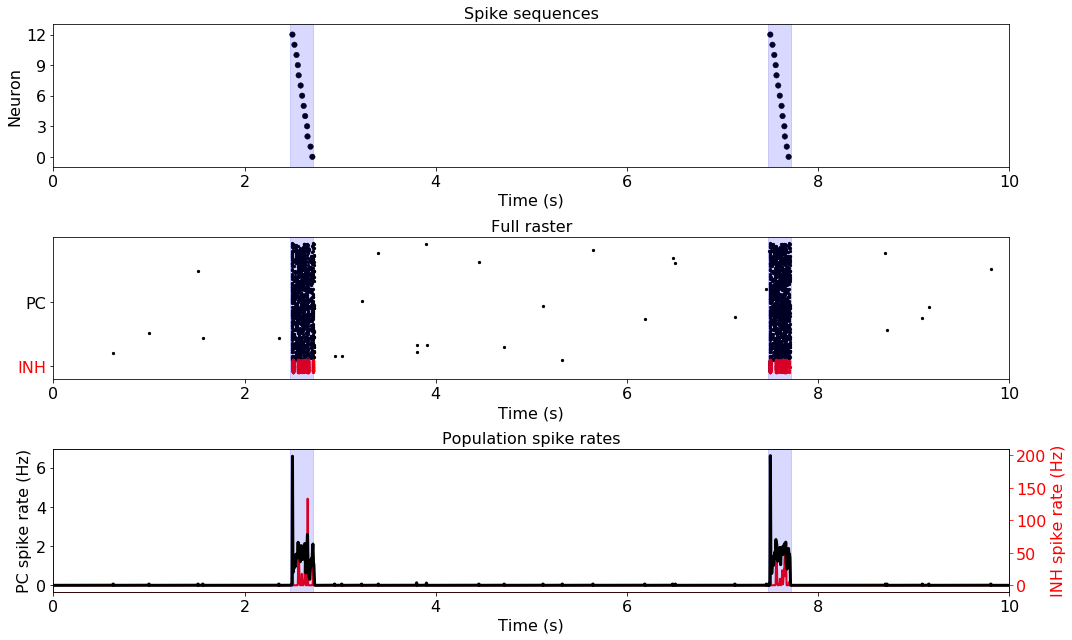

In [4]:
rerun_smln(
    'PARAM_SWEEP_RESULTS_4_R_G_SGM_MAX.txt',
    smln_id=178,
    rng_seed=0,
    d_smln=10,
    trg=[
        {'T': 2.5, 'A': 0.01, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
        {'T': 7.5, 'A': 0.01, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    change_m_params={'R_G': 200, 'W_PC_G': .005},
    epochs=[(2.48, 2.72), (7.48, 7.72)],
    t_lim=(0, 10));